In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from matplotlib.pylab import rcParams
from scipy.integrate import solve_ivp
import math
from scipy.special import hermitenorm as hermite
import scipy.integrate as integrate
from sklearn.linear_model import LinearRegression
from numpy.polynomial.hermite_e import hermeval, hermegauss
from itertools import product
from numpy.polynomial.legendre import legval, leggauss
from scipy.special import legendre 
import random
from sklearn.metrics import mean_squared_error

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from NormalScoreTransform import *
from aPCE import *
import seaborn as sns

In [3]:
from AFVB_PCE import *

## Example from Oladyshkin Paper

In [4]:
N = 500 # Sample size
N_mc = 10000
d = 1  # d --> number of random variables
p = 8 # p --> degree of PCE polynomial
n_quad = 10

### Creating Data

In [5]:
# Mixture of Gaussian and log-Gaussian
z = np.random.uniform(0, 1, N) < 0.6 # assume mixture coefficients are (0.8,0.2)
dat = np.zeros(N)
for i in range(N):
    if z[i] == True:
        dat[i] = np.random.normal(1.5, 0.5, 1)
    else:
        dat[i] = np.random.lognormal(1, 0.25, 1)
        
noise = np.random.normal(0, 0.01, N) 
dat += noise

dat = np.c_[dat]

In [6]:
# Creating Test Data
z = np.random.uniform(0, 1, N) < 0.6 # assume mixture coefficients are (0.8,0.2)
dat2 = np.zeros(N)
for i in range(N):
    if z[i] == True:
        dat2[i] = np.random.normal(1.5, 0.5, 1)
    else:
        dat2[i] = np.random.lognormal(1, 0.25, 1)
        
noise = np.random.normal(0, 0.01, N) 
dat2 += noise

In [7]:
### PCE Data
### Transforming data to be normal

nst = NormalScoreTransform(
    dat, np.ones_like(dat),
    0, 30,
    0, 1,
    15, 1)
nst.create_transform_func()

dat_pce = nst.transform(dat)

/Users/chave/anaconda3/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:698: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/chave/anaconda3/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


In [8]:
### MC Data

z_mc = np.random.uniform(0, 1, N_mc) < 0.6 # assume mixture coefficients are (0.8,0.2)
dat_mc = np.zeros(N_mc)
for i in range(N_mc):
    if z_mc[i] == True:
        dat_mc[i] = np.random.normal(1.5, 0.5, 1)
    else:
        dat_mc[i] = np.random.lognormal(1, 0.25, 1)

In [9]:
dat_mc = np.exp(-dat_mc*1)
y_mc_var = np.var(np.exp(-dat_mc))

y_mc = np.mean(dat_mc)
y_mc

0.18289655558511547

### aPCE

In [10]:
def exp(X):
    return np.c_[np.exp(-X)]

mod = aPCE(dat, p, exp)
pce_coef_Quad = mod.Quadrature(n_quad)
pce_coef_LR = mod.LR()

In [11]:
def evaluate_aPCE_exp(pce_coef, d, max_deg, x):
    """
    evaluate pce expansion with maximum degree max_deg at the points x
    for Black-Scholes
    input:
    pce_coef: 1d array, the pce coefficients
    d: int, the number of parameter
    max_deg: int, the maximum degree
    x: 2d array, the points where the pce is evaluated. x.shape[1] = 3
    return
    val: 1d array of the same size as x.shape[0]
    """
    pce_index = mod.multivariate_pce_index(d, max_deg)
    val = np.zeros(x.shape[0])
    for i in range(pce_index.shape[0]):    
        val += pce_coef[i]*\
               (mod.Pol_eval(mod.Create_Orthonormal_Polynomials('Quadrature')[0][0][pce_index[i][0]], x)).reshape(N)
    return val

In [12]:
def evaluate_aPCE_exp2(pce_coef, d, max_deg, x):
    """
    evaluate pce expansion with maximum degree max_deg at the points x
    for Black-Scholes
    input:
    pce_coef: 1d array, the pce coefficients
    d: int, the number of parameter
    max_deg: int, the maximum degree
    x: 2d array, the points where the pce is evaluated. x.shape[1] = 3
    return
    val: 1d array of the same size as x.shape[0]
    """
    pce_index = mod.multivariate_pce_index(d, max_deg)
    val = np.zeros(x.shape[0])
    for i in range(pce_index.shape[0]):    
        val += pce_coef[i]*\
               (mod.Pol_eval(mod.Create_Orthonormal_Polynomials('LR')[0][pce_index[i][0]], x)).reshape(N)
    return val

In [13]:
np.mean(evaluate_aPCE_exp(pce_coef_Quad, d, p, dat2))

0.18314530002276638

In [14]:
y_aPCE_Quad = evaluate_aPCE_exp(pce_coef_Quad, d, p, dat2)
y_aPCE_LR = evaluate_aPCE_exp2(pce_coef_LR, d, p, dat2)

y_true = exp(dat2)

### PCE

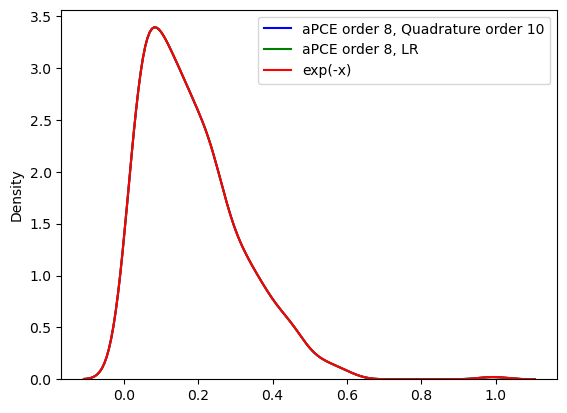

In [15]:
sns.kdeplot(y_aPCE_Quad, color='b', label='aPCE order 8, Quadrature order 10')
sns.kdeplot(y_aPCE_LR, color='g', label='aPCE order 8, LR')
sns.kdeplot(y_true.reshape(N), color='r', label='exp(-x)')
plt.legend();

## Ishigami Function

In [4]:
N = 80 # Sample size
N_test = 100
d = 3  # d --> number of random variables
p = 8 # p --> degree of PCE polynomial
n_quad = 10

### Data

In [5]:
random.seed(12)
Z = np.random.uniform(-np.pi,np.pi, size=(N, d))
Z_test = np.random.uniform(-np.pi,np.pi, size=(N_test, d))

### aPCE

In [6]:
def Ishigami_Function(X):
    return np.c_[np.sin(X[:,0]) + 7*(np.sin(X[:,1]))**2 + 0.1*X[:,2]**4*np.sin(X[:,0])]

In [7]:
mod = aPCE(Z, p, Ishigami_Function)
pce_coef_Quad = mod.Quadrature(n_quad)
pce_coef_LR = mod.LR()

In [8]:
def evaluate_aPCE_Ishigami(pce_coef, d, max_deg, x):
    """
    evaluate pce expansion with maximum degree max_deg at the points x
    for Black-Scholes
    input:
    pce_coef: 1d array, the pce coefficients
    d: int, the number of parameter
    max_deg: int, the maximum degree
    x: 2d array, the points where the pce is evaluated. x.shape[1] = 3
    return
    val: 1d array of the same size as x.shape[0]
    """
    pce_index = mod.multivariate_pce_index(d, max_deg)
    val = np.zeros(x.shape[0])
    for i in range(pce_index.shape[0]):    
        val += pce_coef[i]*\
               mod.Pol_eval(mod.Create_Orthonormal_Polynomials('Quadrature')[0][0][pce_index[i,0],:], x[:,0])*\
               mod.Pol_eval(mod.Create_Orthonormal_Polynomials('Quadrature')[0][1][pce_index[i,1],:], x[:,1])*\
               mod.Pol_eval(mod.Create_Orthonormal_Polynomials('Quadrature')[0][2][pce_index[i,2],:], x[:,2])
    return val

In [9]:
def evaluate_aPCE_Ishigami2(pce_coef, d, max_deg, x):
    """
    evaluate pce expansion with maximum degree max_deg at the points x
    for Black-Scholes
    input:
    pce_coef: 1d array, the pce coefficients
    d: int, the number of parameter
    max_deg: int, the maximum degree
    x: 2d array, the points where the pce is evaluated. x.shape[1] = 3
    return
    val: 1d array of the same size as x.shape[0]
    """
    pce_index = mod.multivariate_pce_index(d, max_deg)
    val = np.zeros(x.shape[0])
    for i in range(pce_index.shape[0]):    
        val += pce_coef[i]*\
               mod.Pol_eval(mod.Create_Orthonormal_Polynomials('LR')[0][pce_index[i,0],:], x[:,0])*\
               mod.Pol_eval(mod.Create_Orthonormal_Polynomials('LR')[1][pce_index[i,1],:],x[:,1])*\
               mod.Pol_eval(mod.Create_Orthonormal_Polynomials('LR')[2][pce_index[i,2],:], x[:,2])
    return val

In [10]:
y_aPCE_Quad = evaluate_aPCE_Ishigami(pce_coef_Quad, d, p, Z_test)
y_aPCE_LR = evaluate_aPCE_Ishigami2(pce_coef_LR, d, p, Z_test)

y_true = Ishigami_Function(Z_test)

In [11]:
np.mean(evaluate_aPCE_Ishigami(pce_coef_Quad, d, p, Z_test))

3.7002924468464

In [12]:
np.mean(y_true)

3.7038879383444923

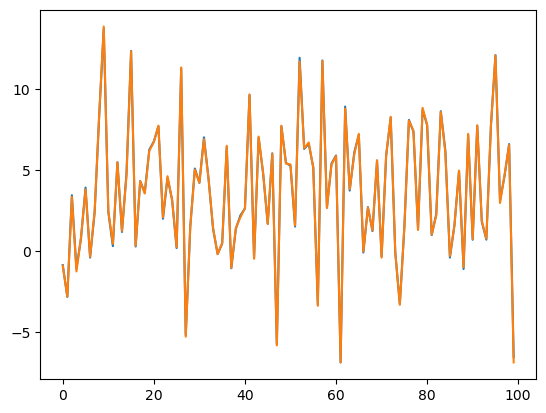

In [13]:
plt.plot(Ishigami_Function(Z_test))
plt.plot(evaluate_aPCE_Ishigami(pce_coef_Quad, d, p, Z_test))

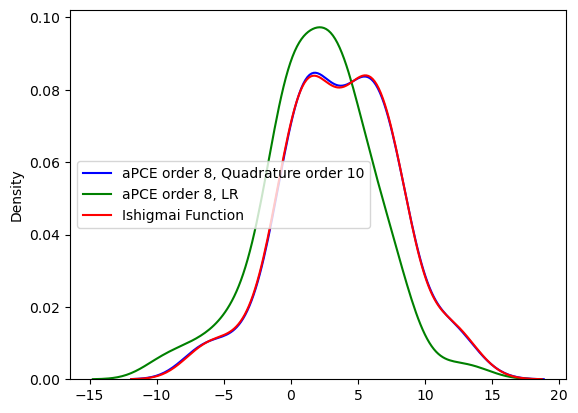

In [14]:
sns.kdeplot(y_aPCE_Quad, color='b', label='aPCE order 8, Quadrature order 10')
sns.kdeplot(y_aPCE_LR, color='g', label='aPCE order 8, LR')
sns.kdeplot(y_true.reshape(N_test), color='r', label='Ishigmai Function')
plt.legend();

## aPCE and AFVB method from Bhattacharyya

In [15]:
################
#### Inputs ####
################
n = int(math.factorial(d + p)/(math.factorial(d)*math.factorial(p))) # n --> Number of terms in the PCE expansion
# A_0 and B_0 --> the parameters of the Gamma distribution in the joint Gaussian-Gamma 
# distribution used to express the prior
A_0 = 0.1 
B_0 = 0.0001 
# C_0 and D_0 --> the paramters of the Gamma distribution in the distribution of the hyper-prior
C_0 = 0.1
D_0 = 0.0001 
T_ell = 0.001 # T_ell --> threshold value for the VLB (for the error e_ell) in percent
e = 1000 # e --> ddjustable parameter for the threshold value 

In [16]:
data={'Xi':Z}
data['Y'] = Ishigami_Function(data['Xi'])

In [17]:
def basis(Z):
    P = mod.Create_Orthonormal_Polynomials('LR')
        
    idx = mod.multivariate_pce_index(d, p)
    Phi = np.ones((N, n))

    for i in range(n):
        for j in range(d):
            Phi[:,i] *=  mod.Pol_eval(P[j][idx[i][j],:], Z[:,j])
    return Phi

In [18]:
def basis2(dat, N):
    P = mod.Create_Orthonormal_Polynomials('LR')
        
    idx = mod.multivariate_pce_index(d, p)
    Phi = np.ones((N, n))

    for i in range(n):
        for j in range(d):
            Phi[:,i] *=  mod.Pol_eval(P[j][idx[i][j],:], dat[:,j])
    return Phi

In [19]:
params = {'A_0' : A_0, 'B_0': B_0, 'C_0': C_0, 'D_0': D_0}
mod_AFVB = AFVB_PCE(params, p, data, basis)
Phi_hat, a_hat, Phi_full, a_full, active_cols = mod_AFVB.algorithm(T_ell, e)

1 (80, 165) -27.463139341317458
2 (80, 163) -31.955800832342675
3 (80, 154) -52.090849866636916
4 (80, 144) -74.41502306577792
5 (80, 122) -138.56320040584467
6 (80, 101) -111.50518095497918
7 (80, 84) -89.63125530304256
8 (80, 71) -72.92705489846975
9 (80, 67) -67.7950030428031
10 (80, 61) -60.10982678233839
11 (80, 56) -53.71300155707388
12 (80, 49) -44.77573734793364
13 (80, 46) -40.9497165769304
14 (80, 45) -39.67731722409496
15 (80, 43) -37.137212576871036
16 (80, 42) -35.87107847836789
17 (80, 40) -33.34316713364795
18 (80, 39) -32.083578570012236
19 (80, 38) -30.827090656824822
20 (80, 37) -29.97659454869327
21 (80, 36) -29.15202164112553
22 (80, 35) -28.271254038879817
23 (80, 34) -27.977115149018275
24 (80, 33) -27.703953071857455
25 (80, 32) -27.8112310189385
26 (80, 31) -27.459134377874918
27 (80, 30) -28.16594981425557
28 (80, 29) -28.129023505281275
29 (80, 28) -29.19831071707314
30 (80, 27) -30.305124963682665
31 (80, 26) -29.420253838716967
32 (80, 25) -29.46039848445380

In [20]:
a_hat.shape

(31, 1)

In [21]:
Phi_hat.shape

(80, 31)

In [22]:
active_cols

array([  0,   2,   4,   9,  16,  17,  24,  30,  35,  39,  42,  44,  45,
        46,  47,  48,  49,  64,  81,  83,  88,  91, 109, 110, 111, 112,
       113, 114, 116, 145, 147])

In [23]:
Phi_test = basis2(Z_test, N_test)[:,active_cols]
Phi_test_full = basis2(Z_test, N_test)

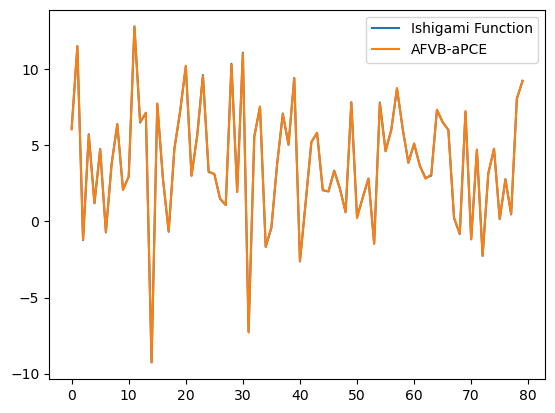

In [24]:
plt.plot(data['Y'], label = "Ishigami Function")
plt.plot(Phi_hat@a_hat, label = "AFVB-aPCE")
plt.legend();

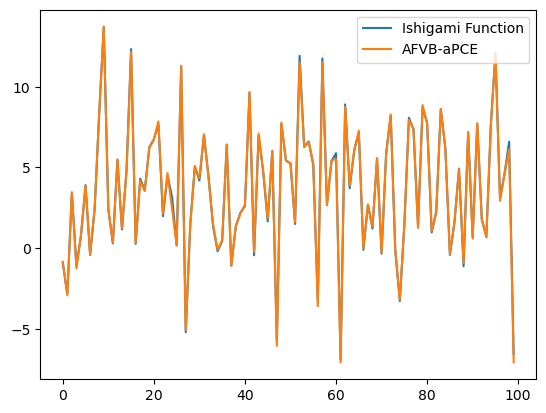

In [25]:
plt.plot(Ishigami_Function(Z_test), label = "Ishigami Function")
plt.plot(Phi_test@a_hat, label = "AFVB-aPCE")
plt.legend();

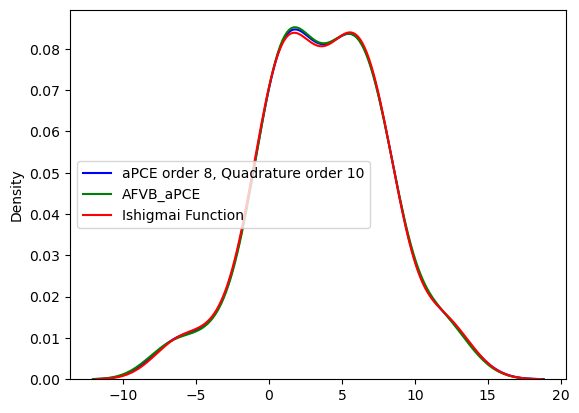

In [26]:
sns.kdeplot(y_aPCE_Quad.reshape(N_test), color='b', label='aPCE order 8, Quadrature order 10')
sns.kdeplot((Phi_test@a_hat).reshape(N_test), color='g', label='AFVB_aPCE')
sns.kdeplot(Ishigami_Function(Z_test).reshape(N_test), color='r', label='Ishigmai Function')
plt.legend();

In [27]:
print("RMSE_full - Testing Data:", mean_squared_error(Ishigami_Function(Z_test), Phi_test_full@a_full))
print("RMSE-AFVB_sparse - Testing Data:", mean_squared_error(Ishigami_Function(Z_test), Phi_test@a_hat))


RMSE_full - Testing Data: 0.021345867394379305
RMSE-AFVB_sparse - Testing Data: 0.023113441888149216


In [28]:
print("RMSE-Quad - Testing Data:", mean_squared_error(Ishigami_Function(Z_test), y_aPCE_Quad))
      

RMSE-Quad - Testing Data: 0.00613177090975764


In [29]:
print("RMSE_full - Training Data:", mean_squared_error(Ishigami_Function(Z), Phi_full@a_full))
print("RMSE_sparse - Training Data:", mean_squared_error(Ishigami_Function(Z), Phi_hat@a_hat))


RMSE_full - Training Data: 0.0004535672857805203
RMSE_sparse - Training Data: 0.0010886226039887499


### PCE

In [ ]:
#### Next....
#### Try to implement the sparse modeling done in Bhattacharys paper and Tsilifis
#### Look at sobol indices ---> Look at index matrix

#### Read future work and conclusion on paper and see if they had problems that might be solved by using sparse model
#### We can think about possible directions that we can follow

## PCE

In [ ]:
"""
The module contains ...
Add description

__author__ = 'Isabel Corona Guevara'
__version__ = '0.1'
"""

import numpy as np
from sklearn.linear_model import LinearRegression
import math
from itertools import product

class PCE(object):
    """
    Description Here
    
    """

    def __init__(self, data, p, model):
        """
        Implement the initializer of aPCE class.

        data: array, is of size (n_sample, n_param)
        p: integer, the degree of the PCE
        model: function, the model, the model takes a numpy array
               of size (n_sample, n_param) as input and the output
               is of size (n_sample, n_outputs)
        method: string, method used to calculate the coefficients of the PCE
                choices from 'LR' (Linear Regression) and 'Quadrature'
        q: Number of Quadrature points used for method = "Quadrature"

        """
        
        self.data = data
        self.p = p
        self.model = model
        self.N = data.shape[0] # sample size
        self.d = data.shape[1] # number of parameters
        self.n = int(math.factorial(self.d + p)/(math.factorial(self.d)*math.factorial(p))) # number of terms in PCE
       
    
    ## Checking Polynomials we created are orthogonal
    def Pol_eval(self, coeff, x):
        """
        
        """
        
        deg = coeff.shape[0]
        val = 0
        for i in range(deg):
            val += coeff[i]*x**i

        return val

    def Int_eval(self, coeff1, coeff2, dat):
        """
        
        """
        
        s = np.mean(self.Pol_eval(coeff1, dat)*self.Pol_eval(coeff2, dat))
        
        return s
    
    def Create_Orthonormal_Polynomials(self, method, n_quad = 10):
        """
        
        """
        
        P = []
        P_quad = []
        
        if method == "LR":
        
            for j in range(self.d):
                # Creating Orthogonal Polynomials
                P_temp = np.zeros((self.p+1, self.p+1))

                P_temp[0,0] = 1

                mu = np.zeros(2*self.p) 
                for i in range(2*self.p): 
                    mu[i] = np.mean(self.data[:,j]**i)

                mu_mat = np.zeros((self.p, self.p+1))
                for i in range(self.p):
                    mu_mat[i,:] = mu[i:(self.p+1+i)]

                for i in range(1,self.p+1):
                    A = np.zeros((i+1, i+1))
                    A[-1,-1] = 1
                    A[0:i,:] = mu_mat[0:i, 0:i+1]
                    b = A[-1]
                    a = np.zeros(self.p+1)
                    a[0:i+1] = np.linalg.inv(A)@b
                    P_temp[i, :] = a.transpose()

                # Normalizing Polynomials
                P_temp_norm = np.zeros((self.p+1, self.p+1))
                for i in range(self.p+1):
                    P_temp_norm[i,:] = P_temp[i,:]/np.sqrt(self.Int_eval(P_temp[i,:], P_temp[i,:], self.data[:,j]))
                
                
                # Adding Matrix with Polynomial Coefficients to P
                P.append(P_temp_norm)
                
            return P
                
        if method == "Quadrature":
                    
            for j in range(self.d):
                # Creating Orthogonal Polynomials of size n_quad
                P_quad_temp = np.zeros((n_quad+1, n_quad+1))

                P_quad_temp[0,0] = 1

                mu = np.zeros(2*n_quad) 
                for i in range(2*n_quad): 
                    mu[i] = np.mean(self.data[:,j]**i)

                mu_mat = np.zeros((n_quad, n_quad+1))
                for i in range(n_quad):
                    mu_mat[i,:] = mu[i:(n_quad+1+i)]

                for i in range(1, n_quad+1):
                    A = np.zeros((i+1, i+1))
                    A[-1,-1] = 1
                    A[0:i,:] = mu_mat[0:i, 0:i+1]
                    b = A[-1]
                    a = np.zeros(n_quad+1)
                    a[0:i+1] = np.linalg.inv(A)@b
                    P_quad_temp[i, :] = a.transpose()

                # Normalizing Polynomials
                P_quad_temp_norm = np.zeros((n_quad+1, n_quad+1))
                for i in range(n_quad+1):
                    P_quad_temp_norm[i,:] = P_quad_temp[i,:]/np.sqrt(self.Int_eval(P_quad_temp[i,:], P_quad_temp[i,:], self.data[:,j]))

                # Creating matrix of polynomial coefficients of size p+1
                P_temp_norm = P_quad_temp_norm[0:self.p+1, 0:self.p+1]
                
                # Adding Matrix with Polynomial Coefficients to P
                P.append(P_temp_norm)
                P_quad.append(P_quad_temp_norm)
            
        
            return P, P_quad
    
    
    def multivariate_pce_index(self, d, max_deg):
        """
        Generate all the d-dimensional polynomial indices with the 
        constraint that the sum of the indexes is <= max_deg

        input:
        d: int, number of random variables
        max_deg: int, the max degree allowed

        return: 
        2d array with shape[1] equal to d, the multivariate indices
        """
        maxRange = max_deg*np.ones(d, dtype = 'int')
        index = np.array([i for i in product(*(range(i + 1) for i in maxRange)) if sum(i) <= max_deg])
        return index
    
    def multivariate_pce_index_quad(self, d, max_deg):
        """
        Generate all the d-dimensional polynomial indices with the 
        constraint that the sum of the indexes is <= max_deg

        input:
        d: int, number of random variables
        max_deg: int, the max degree allowed

        return: 
        2d array with shape[1] equal to d, the multivariate indices
        """
        maxRange = max_deg*np.ones(d, dtype = 'int')
        index = np.array([i for i in product(*(range(i + 1) for i in maxRange)) if max(i) <= max_deg])
        return index
    
    
    def Quadrature(self, n_quad = 10):
        """
        Compute the pce coefficients of the Ishigami Function
        input:
        d: int, number of parameters
        max_deg: int, the max degree so that individual degrees
                 are not above it
        n_quad: int, number of quadrature points
        return:
        1d array, PCE coefficients
        """
        pce_index = self.multivariate_pce_index(self.d, self.p)
        pce_coef = np.zeros(pce_index.shape[0])

        P = self.Create_Orthonormal_Polynomials('Quadrature', n_quad)[0]
        P_quad = self.Create_Orthonormal_Polynomials('Quadrature', n_quad)[1]

        w = []
        nodes = []

        for j in range(self.d):

            # Finding the weights for each parameter
            nodes_temp = np.roots(P_quad[j][-1][::-1])
            V = np.zeros((n_quad, n_quad))
            for i in range(n_quad):
                V[i,:] = nodes_temp**i
            b_cond = np.zeros(n_quad)
            for i in range(n_quad):
                b_cond[i] = np.mean(self.data[:,j]**i)
            w_temp = np.linalg.inv(V)@b_cond

            w.append(w_temp)
            nodes.append(nodes_temp)

        quad_index = self.multivariate_pce_index_quad(self.d, n_quad-1)
        
        for i in range(pce_coef.size):
            for j in range(quad_index.shape[0]):
                w_P = 1
                Z = np.zeros((1, self.d))
                for k in range(self.d):
                    w_P *= w[k][quad_index[j,k]]*self.Pol_eval(P[k][pce_index[i,k],:], nodes[k][quad_index[j,k]])
                    Z[:,k] = nodes[k][quad_index[j,k]]
                    
                pce_coef[i] += w_P*self.model(Z)

        return pce_coef
    
    def LR(self):
        """
        
        """
        
        P = self.Create_Orthonormal_Polynomials('LR')
        
        index = self.multivariate_pce_index(self.d, self.p)
        Phi = np.ones((self.N, self.n))

        for i in range(self.n):
            for j in range(self.d):
                Phi[:,i] *=  self.Pol_eval(P[j][index[i][j],:], self.data[:,j])
        
        Y = self.model(self.data)
        mod = LinearRegression(fit_intercept = False).fit(Phi, Y)
        
        return mod.coef_.reshape(self.n)

### PCE using Gauss Quadrature

In [388]:
#### This is assuming data is normal but not standard normal
# ?????????? should the weights be the same for all calculations of the constants c_i's ??

n_quad = 32
nodes = hermegauss(n_quad)[0] # roots
w = hermegauss(n_quad)[1]
c_pce = np.zeros(n)
for i in range(n):
    c_pce[i] = np.dot(w, np.exp(-np.mean(dat)-np.std(dat)*nodes)*hermite(i)(nodes))\
    /(np.sqrt(2*np.pi)*math.factorial(i))

In [389]:
y_PCE = np.mean(hermeval((dat-np.mean(dat))/np.std(dat), c_pce))
y_PCE

0.18241954439820932

In [390]:
np.std(dat_pce)

0.9987060381211048

In [391]:
#### This is assuming data is not normal so we transform it using score transform
## Problem is... I think we need to transform it back at some point but getting error in function

n_quad = 32
nodes = hermegauss(n_quad)[0] # roots
w = hermegauss(n_quad)[1]
c_pce2 = np.zeros(n)
for i in range(n):
    c_pce2[i] = np.dot(w, np.exp(-nodes)*hermite(i)(nodes))\
    /(np.sqrt(2*np.pi)*math.factorial(i))

In [392]:
w_t = nst.back_transform(c_pce2)
#### Try transforming w instead ???? 
w_t

array([3.57036017, 0.82057974, 2.74405123, 1.67010167, 1.92954211,
       1.84623098, 1.85924765, 1.85921159, 1.85921666, 1.85921603,
       1.8592161 ])

In [393]:
nst.back_transform(hermeval(dat_pce, c_pce2))

ValueError: NumPy boolean array indexing assignment cannot assign 0 input values to the 65 output values where the mask is true

### Making a Function for PCE

In [394]:
def PCE(p, dat):
    #### This is assuming data is normal but not standard normal
    # ?????????? should the weights be the same for all calculations of the constants c_i's ??
    n = int(math.factorial(d + p)/(math.factorial(d)*math.factorial(p)))
    
    n_quad = 32
    nodes = hermegauss(n_quad)[0] # roots
    w = hermegauss(n_quad)[1]
    c_pce = np.zeros(n)
    for i in range(n):
        c_pce[i] = np.dot(w, np.exp(-np.mean(dat)-np.std(dat)*nodes)*hermite(i)(nodes))\
        /(np.sqrt(2*np.pi)*math.factorial(i))
        
    return hermeval((dat-np.mean(dat))/np.std(dat), c_pce)

In [395]:
np.mean(PCE(6, dat))

0.18254738751611946

## MC

In [396]:
y_mc = np.mean(np.exp(-dat_mc*1))
y_mc_var = np.var(np.exp(-dat_mc))

y_mc

0.18275267488451735

## aPCE

In [397]:
#### Calculating the Orthogonal Polynomials
P = np.zeros((p+1, p+1))

P[0,0] = 1

mu = np.zeros(2*p) 
for i in range(2*p): 
    mu[i] = np.mean(dat**i)
    
mu_mat = np.zeros((p, p+1))
for i in range(p):
    mu_mat[i,:] = mu[i:(p+1+i)]
    
for i in range(1,p+1):
    A = np.zeros((i+1, i+1))
    A[-1,-1] = 1
    A[0:i,:] = mu_mat[0:i, 0:i+1]
    b = A[-1]
    a = np.zeros(p+1)
    a[0:i+1] = np.linalg.inv(A)@b
    P[i, :] = a.transpose()

In [398]:
## Checking Polynomials we created are orthogonal
def Pol_eval(coeff, x):
    deg = coeff.shape[0]
    val = 0
    for i in range(deg):
        val += coeff[i]*x**i
        
    return val

In [399]:
def Int_eval(coeff1, coeff2, dat):
    s = np.mean(Pol_eval(coeff1, dat)*Pol_eval(coeff2, dat))
    return s

In [400]:
for i in range(p+1):
    print(Int_eval(P[3,:], P[i,:], dat))

-1.602273869139026e-15
2.4726887204451486e-14
-1.2224177226016764e-13
2.652809140889861
-2.3291590878216085e-12
1.7708259747450938e-11
-1.7821787423599745e-10
-4.453399640169664e-10
-7.30897991729762e-09
1.0597912853427261e-07
2.559293534432072e-08


In [401]:
P_norm = np.zeros((p+1, p+1))
for i in range(p+1):
    P_norm[i,:] = P[i,:]/np.sqrt(Int_eval(P[i,:], P[i,:], dat))

In [402]:
P_norm

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-2.30945109e+00,  1.14552778e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 4.24699988e+00, -4.34850383e+00,  9.36452993e-01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-6.58056049e+00,  1.05000596e+01, -4.71042833e+00,
         6.13969783e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 1.00312737e+01, -2.33431567e+01,  1.69608071e+01,
        -4.72775425e+00,  4.38035101e-01,  0.00000000e+00,
  

In [403]:
for i in range(p+1):
    print(Int_eval(P_norm[3,:], P_norm[i,:], dat))

-1.2505552149377763e-15
1.7429613308195256e-14
-7.095479759300361e-14
0.9999999999999997
-6.282334652496502e-13
3.33422178755427e-12
-2.3969313645011424e-11
-4.902303807341468e-11
-6.799279397284863e-10
8.187892902355998e-09
1.4521316558102626e-09


### Checking Weights on Legendre Polynomials

In [404]:
legendre(2)

poly1d([ 1.5,  0. , -0.5])

In [405]:
np.roots(hermite(2))

array([-1.,  1.])

In [406]:
import scipy.integrate as integrate
import scipy.special as special

In [407]:
integrate.quad(lambda x: x**0, -np.inf, np.inf)[0]

/var/folders/6l/nmzh70mx64s3ykd63cty8kg80000gn/T/ipykernel_50077/1731710399.py:1: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integrate.quad(lambda x: x**0, -np.inf, np.inf)[0]


-2.0

In [408]:
# Finding the weights for c_i

## ???? For some reason, np.roots gives me the negative of the roots for the legendre polynomial
## ???? The weights are correct, but they are given in a different order
nodes_H = -1*np.roots(legendre(p+1))
V_H = np.zeros((p+1,p+1))
for i in range(p+1):
    V_H[i,:] = nodes_H**i
b_cond_H = np.zeros(p+1)
for i in range(p+1):
    b_cond_H[i] = integrate.quad(lambda x: x**i, -1, 1)[0]
w_s_H = np.linalg.inv(V_H)@b_cond_H

In [409]:
w_s_H

array([0.05566857, 0.12558037, 0.18629021, 0.23319376, 0.26280454,
       0.05566857, 0.12558037, 0.18629021, 0.23319376, 0.26280454,
       0.27292509])

In [410]:
np.roots(legendre(p+1))

array([ 0.97822866,  0.8870626 ,  0.73015201,  0.51909613,  0.26954316,
       -0.97822866, -0.8870626 , -0.73015201, -0.51909613, -0.26954316,
        0.        ])

In [411]:
leggauss(p+1)

(array([-0.97822866, -0.8870626 , -0.73015201, -0.51909613, -0.26954316,
         0.        ,  0.26954316,  0.51909613,  0.73015201,  0.8870626 ,
         0.97822866]),
 array([0.05566857, 0.12558037, 0.18629021, 0.23319376, 0.26280454,
        0.27292509, 0.26280454, 0.23319376, 0.18629021, 0.12558037,
        0.05566857]))

### aPCE using Gauss Quadrature

In [412]:
# Finding the weights for c_i
nodes = np.roots(P_norm[-1][::-1])
V = np.zeros((p,p))
for i in range(p):
    V[i,:] = nodes**i
b_cond = np.zeros(p)
for i in range(p):
    b_cond[i] = np.mean(dat**i)
w_s = np.linalg.inv(V)@b_cond

In [413]:
b_cond

array([1.00000000e+00, 2.01605857e+00, 4.82655141e+00, 1.32693012e+01,
       4.08681517e+01, 1.38344692e+02, 5.07342413e+02, 1.99307384e+03,
       8.30881276e+03, 3.64452145e+04])

In [414]:
np.roots(P_norm[-1][::-1])

array([5.57849274, 4.89539773, 4.25198342, 3.60077494, 2.94547186,
       2.24723323, 1.62630398, 1.07859715, 0.60645806, 0.25291133])

In [415]:
P_norm[-1][::-1]

array([ 1.03788047e-01, -2.81095649e+00,  3.26635211e+01, -2.13162859e+02,
        8.58843705e+02, -2.21182771e+03,  3.64440075e+03, -3.73572510e+03,
        2.23285245e+03, -6.82068817e+02,  7.72810127e+01])

In [416]:
c = np.zeros(p+1)
for i in range(p+1):
    c[i] = np.dot(w_s, np.exp(-nodes)*Pol_eval(P_norm[i,:], nodes))

In [417]:
c

array([ 1.82419341e-01, -1.19891363e-01,  5.90332402e-02, -2.51676470e-02,
        8.19382235e-03, -2.17039445e-03,  4.88713012e-04, -8.55553954e-05,
        1.29511111e-05, -1.67773412e-06,  8.00511814e-12])

In [418]:
y_aPCE = np.mean(c[0]*Pol_eval(P_norm[0,:], dat) \
        + c[1]*Pol_eval(P_norm[1,:], dat) \
        + c[2]*Pol_eval(P_norm[2,:], dat) \
        + c[3]*Pol_eval(P_norm[3,:], dat) \
        + c[4]*Pol_eval(P_norm[4,:], dat) \
        + c[5]*Pol_eval(P_norm[5,:], dat) \
        + c[6]*Pol_eval(P_norm[6,:], dat))

y_aPCE

0.18241934144575925

In [419]:
y_pce = c[0]*Pol_eval(P_norm[0,:], dat2) \
        + c[1]*Pol_eval(P_norm[1,:], dat2) \
        + c[2]*Pol_eval(P_norm[2,:], dat2) \
        + c[3]*Pol_eval(P_norm[3,:], dat2) \
        + c[4]*Pol_eval(P_norm[4,:], dat2) \
        + c[5]*Pol_eval(P_norm[5,:], dat2) \
        + c[6]*Pol_eval(P_norm[6,:], dat2)
y_true = np.exp(-dat2)

In [420]:
np.mean(y_pce)

0.18293442557051007

In [421]:
def evaluate_pce_1D(pce_coef, d, max_deg, x):
    """
    evaluate pce expansion with maximum degree max_deg at the points x
    for Black-Scholes
    input:
    pce_coef: 1d array, the pce coefficients
    d: int, the number of parameter
    max_deg: int, the maximum degree
    x: 2d array, the points where the pce is evaluated. x.shape[1] = 3
    return
    val: 1d array of the same size as x.shape[0]
    """
    pce_index = multivariate_pce_index(d, max_deg)
    val = np.zeros(x.shape[0])
    for i in range(pce_index.shape[0]):    
        val += pce_coef[i]*\
               Pol_eval(P_norm[pce_index[i,0],:], x)
    return val

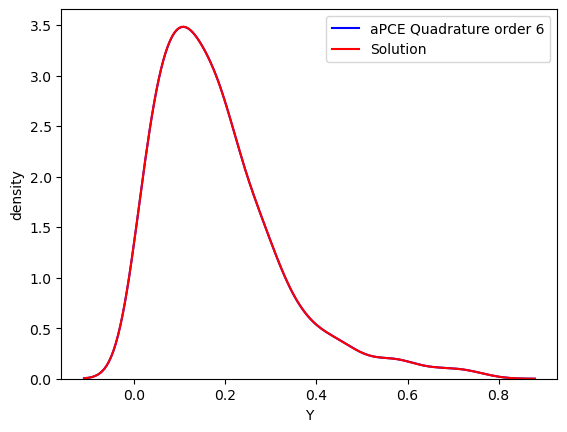

In [422]:
#plt.rcParams['figure.figsize'] = (6, 6)
sns.kdeplot(y_pce, color='b', label='aPCE Quadrature order 6')
sns.kdeplot(y_true, color='r', label='Solution')
plt.legend()
plt.xlabel('Y')
plt.ylabel('density');

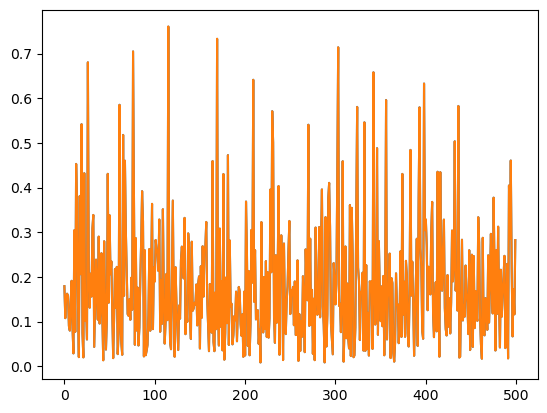

In [423]:
plt.plot(y_pce)
plt.plot(y_true)

### Using Linear Regression to Calculate the Coefficients

In [424]:
Phi = np.zeros((N, n))

for i in range(n):
    Phi[:,i] =  Pol_eval(P_norm[i,:], dat)

In [425]:
model = LinearRegression(fit_intercept = False).fit(Phi, np.exp(-dat))

In [426]:
model.coef_

array([ 1.82419341e-01, -1.19891363e-01,  5.90332402e-02, -2.51676470e-02,
        8.19382234e-03, -2.17039444e-03,  4.88712963e-04, -8.55553529e-05,
        1.29525634e-05, -1.69836054e-06,  2.03748720e-07])

In [427]:
Phi2 = np.zeros((N, n))

for i in range(n):
    Phi2[:,i] =  Pol_eval(P_norm[i,:], dat2)

In [428]:
y_aPCE_LR = Phi2@model.coef_

In [429]:
np.mean(y_aPCE_LR)

0.18292389289523017

In [430]:
y_aPCE_LR.shape

(500,)

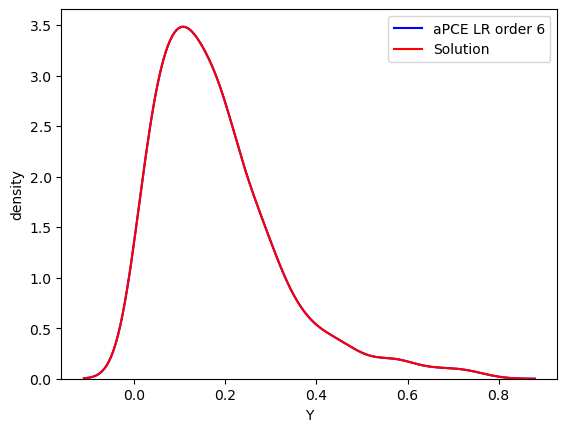

In [431]:
#plt.rcParams['figure.figsize'] = (6, 6)
sns.kdeplot(y_aPCE_LR, color='b', label='aPCE LR order 6')
sns.kdeplot(y_true, color='r', label='Solution')
plt.legend()
plt.xlabel('Y')
plt.ylabel('density');

In [432]:
(np.mean(y_aPCE_LR)-y_mc)/y_mc

0.0009368837464130913

### Multidimensional aPCE on the Ishigami Function

In [436]:
N = 500 # Sample size
d = 3  # d --> number of random variables
p = 10 # p --> degree of PCE polynomial
n = int(math.factorial(d + p)/(math.factorial(d)*math.factorial(p))) # number of terms in PCE

In [437]:
def Ishigami_Function(x1,x2,x3):
    return np.c_[np.sin(x1) + 7*(np.sin(x2))**2 + 0.1*x3**4*np.sin(x1)]

In [438]:
# Generating data x_1, x_2, and x_3
Z = np.random.uniform(-np.pi,np.pi, size=(N,3))

x_1 = Z[:,0]
x_2 = Z[:,1]
x_3 = Z[:,2]

Y = np.c_[np.sin(x_1) + 7*(np.sin(x_2))**2 + 0.1*x_3**4*np.sin(x_1)]

In [439]:
#### Calculating the Orthogonal Polynomials corresponding to x_1
P1 = np.zeros((p+1, p+1))

P1[0,0] = 1

mu = np.zeros(2*p) 
for i in range(2*p): 
    mu[i] = np.mean(x_1**i)
    
mu_mat = np.zeros((p, p+1))
for i in range(p):
    mu_mat[i,:] = mu[i:(p+1+i)]
    
for i in range(1,p+1):
    A = np.zeros((i+1, i+1))
    A[-1,-1] = 1
    A[0:i,:] = mu_mat[0:i, 0:i+1]
    b = A[-1]
    a = np.zeros(p+1)
    a[0:i+1] = np.linalg.inv(A)@b
    P1[i, :] = a.transpose()

In [440]:
q = 10

In [441]:
#### Calculating the Orthogonal Polynomials corresponding to x_1
#### For Quadrature
P1_q = np.zeros((q+1, q+1))

P1_q[0,0] = 1

mu = np.zeros(2*q) 
for i in range(2*q): 
    mu[i] = np.mean(x_1**i)
    
mu_mat = np.zeros((q, q+1))
for i in range(q):
    mu_mat[i,:] = mu[i:(q+1+i)]
    
for i in range(1,q+1):
    A = np.zeros((i+1, i+1))
    A[-1,-1] = 1
    A[0:i,:] = mu_mat[0:i, 0:i+1]
    b = A[-1]
    a = np.zeros(q+1)
    a[0:i+1] = np.linalg.inv(A)@b
    P1_q[i, :] = a.transpose()

In [442]:
#### Calculating the Orthogonal Polynomials corresponding to x_2
P2 = np.zeros((p+1, p+1))

P2[0,0] = 1

mu = np.zeros(2*p) 
for i in range(2*p): 
    mu[i] = np.mean(x_2**i)
    
mu_mat = np.zeros((p, p+1))
for i in range(p):
    mu_mat[i,:] = mu[i:(p+1+i)]
    
for i in range(1,p+1):
    A = np.zeros((i+1, i+1))
    A[-1,-1] = 1
    A[0:i,:] = mu_mat[0:i, 0:i+1]
    b = A[-1]
    a = np.zeros(p+1)
    a[0:i+1] = np.linalg.inv(A)@b
    P2[i, :] = a.transpose()

In [443]:
#### Calculating the Orthogonal Polynomials corresponding to x_2
#### For Quadrature
P2_q = np.zeros((q+1, q+1))

P2_q[0,0] = 1

mu = np.zeros(2*q) 
for i in range(2*q): 
    mu[i] = np.mean(x_2**i)
    
mu_mat = np.zeros((q, q+1))
for i in range(q):
    mu_mat[i,:] = mu[i:(q+1+i)]
    
for i in range(1,q+1):
    A = np.zeros((i+1, i+1))
    A[-1,-1] = 1
    A[0:i,:] = mu_mat[0:i, 0:i+1]
    b = A[-1]
    a = np.zeros(q+1)
    a[0:i+1] = np.linalg.inv(A)@b
    P2_q[i, :] = a.transpose()

In [444]:
#### Calculating the Orthogonal Polynomials corresponding to x_3
P3 = np.zeros((p+1, p+1))

P3[0,0] = 1

mu = np.zeros(2*p) 
for i in range(2*p): 
    mu[i] = np.mean(x_3**i)
    
mu_mat = np.zeros((p, p+1))
for i in range(p):
    mu_mat[i,:] = mu[i:(p+1+i)]
    
for i in range(1,p+1):
    A = np.zeros((i+1, i+1))
    A[-1,-1] = 1
    A[0:i,:] = mu_mat[0:i, 0:i+1]
    b = A[-1]
    a = np.zeros(p+1)
    a[0:i+1] = np.linalg.inv(A)@b
    P3[i, :] = a.transpose()

In [445]:
#### Calculating the Orthogonal Polynomials corresponding to x_1
#### For Quadrature
P3_q = np.zeros((q+1, q+1))

P3_q[0,0] = 1

mu = np.zeros(2*q) 
for i in range(2*q): 
    mu[i] = np.mean(x_1**i)
    
mu_mat = np.zeros((q, q+1))
for i in range(q):
    mu_mat[i,:] = mu[i:(q+1+i)]
    
for i in range(1,q+1):
    A = np.zeros((i+1, i+1))
    A[-1,-1] = 1
    A[0:i,:] = mu_mat[0:i, 0:i+1]
    b = A[-1]
    a = np.zeros(q+1)
    a[0:i+1] = np.linalg.inv(A)@b
    P3_q[i, :] = a.transpose()

In [446]:
P1_norm = np.zeros((p+1, p+1))
for i in range(p+1):
    P1_norm[i,:] = P1[i,:]/np.sqrt(Int_eval(P1[i,:], P1[i,:], x_1))

In [447]:
P1_q_norm = np.zeros((q+1, q+1))
for i in range(q+1):
    P1_q_norm[i,:] = P1_q[i,:]/np.sqrt(Int_eval(P1_q[i,:], P1_q[i,:], x_1))

In [448]:
P2_norm = np.zeros((p+1, p+1))
for i in range(p+1):
    P2_norm[i,:] = P2[i,:]/np.sqrt(Int_eval(P2[i,:], P2[i,:], x_2))

In [449]:
####ssss
P2_q_norm = np.zeros((q+1, q+1))
for i in range(q+1):
    P2_q_norm[i,:] = P2_q[i,:]/np.sqrt(Int_eval(P2_q[i,:], P2_q[i,:], x_2))

In [450]:
P3_norm = np.zeros((p+1, p+1))
for i in range(p+1):
    P3_norm[i,:] = P3[i,:]/np.sqrt(Int_eval(P3[i,:], P3[i,:], x_3))

In [451]:
P3_q_norm = np.zeros((q+1, q+1))
for i in range(q+1):
    P3_q_norm[i,:] = P3_q[i,:]/np.sqrt(Int_eval(P3_q[i,:], P3_q[i,:], x_3))

In [110]:
def multivariate_pce_index(d, max_deg):
    """
    Generate all the d-dimensional polynomial indices with the 
    constraint that the sum of the indexes is <= max_deg
    
    input:
    d: int, number of random variables
    max_deg: int, the max degree allowed
    
    return: 
    2d array with shape[1] equal to d, the multivariate indices
    """
    maxRange = max_deg*np.ones(d, dtype = 'int')
    index = np.array([i for i in product(*(range(i + 1) for i in maxRange)) if sum(i) <= max_deg])
    return index

In [453]:
def aPCE_Ishigami_Quadrature(d, max_deg, n_quad):
    """
    Compute the pce coefficients of the Ishigami Function
    input:
    d: int, number of parameters
    max_deg: int, the max degree so that individual degrees
             are not above it
    n_quad: int, number of quadrature points
    return:
    1d array, PCE coefficients
    """
    pce_index = multivariate_pce_index(d, max_deg)
    pce_coef = np.zeros(pce_index.shape[0])
    
    # quadrature
    # Finding the weights for x_1
    nodes1 = np.roots(P1_q_norm[-1][::-1])
    V = np.zeros((n_quad,n_quad))
    for i in range(n_quad):
        V[i,:] = nodes1**i
    b_cond = np.zeros(n_quad)
    for i in range(n_quad):
        b_cond[i] = np.mean(x_1**i)
    w_1 = np.linalg.inv(V)@b_cond
    print(nodes1)
    
    # Finding the weights for x_2
    nodes2 = np.roots(P2_q_norm[-1][::-1])
    V = np.zeros((n_quad,n_quad))
    for i in range(n_quad):
        V[i,:] = nodes2**i
    b_cond = np.zeros(n_quad)
    for i in range(n_quad):
        b_cond[i] = np.mean(x_2**i)
    w_2 = np.linalg.inv(V)@b_cond
    print(nodes2)
    
    # Finding the weights for x_3
    nodes3 = np.roots(P3_q_norm[-1][::-1])
    V = np.zeros((n_quad,n_quad))
    for i in range(n_quad):
        V[i,:] = nodes3**i
    b_cond = np.zeros(n_quad)
    for i in range(n_quad):
        b_cond[i] = np.mean(x_3**i)
    w_3 = np.linalg.inv(V)@b_cond
    print(nodes3)
        
    # the index is for computing the quadrature
    quad_index = multivariate_pce_index(3, n_quad-1)
        
    for i in range(pce_coef.size):
        for j in range(quad_index.shape[0]):
            pce_coef[i] += Ishigami_Function(nodes1[quad_index[j,0]], 
                                             nodes2[quad_index[j,1]], 
                                             nodes3[quad_index[j,2]])*\
            w_1[quad_index[j,0]]*w_2[quad_index[j,1]]*w_3[quad_index[j,2]]*\
            Pol_eval(P1_norm[pce_index[i,0],:], nodes1[quad_index[j,0]])*\
            Pol_eval(P2_norm[pce_index[i,1],:], nodes2[quad_index[j,1]])*\
            Pol_eval(P3_norm[pce_index[i,2],:], nodes3[quad_index[j,2]]) 

    return pce_coef

In [454]:
def aPCE_Ishigami_Quadrature(d, max_deg, n_quad):
    """
    Compute the pce coefficients of the Ishigami Function
    input:
    d: int, number of parameters
    max_deg: int, the max degree so that individual degrees
             are not above it
    n_quad: int, number of quadrature points
    return:
    1d array, PCE coefficients
    """
    pce_index = multivariate_pce_index(d, max_deg)
    pce_coef = np.zeros(pce_index.shape[0])
    
    # quadrature
    # Finding the weights for x_1
    nodes1 = np.roots(P1_q_norm[-1][::-1])
    V = np.zeros((n_quad,n_quad))
    for i in range(n_quad):
        V[i,:] = nodes1**i
    b_cond = np.zeros(n_quad)
    for i in range(n_quad):
        b_cond[i] = np.mean(x_1**i)
    w_1 = np.linalg.inv(V)@b_cond
    
    # Finding the weights for x_2
    nodes2 = np.roots(P2_q_norm[-1][::-1])
    V = np.zeros((n_quad,n_quad))
    for i in range(n_quad):
        V[i,:] = nodes2**i
    b_cond = np.zeros(n_quad)
    for i in range(n_quad):
        b_cond[i] = np.mean(x_2**i)
    w_2 = np.linalg.inv(V)@b_cond
    
    # Finding the weights for x_3
    nodes3 = np.roots(P3_q_norm[-1][::-1])
    V = np.zeros((n_quad,n_quad))
    for i in range(n_quad):
        V[i,:] = nodes3**i
    b_cond = np.zeros(n_quad)
    for i in range(n_quad):
        b_cond[i] = np.mean(x_3**i)
    w_3 = np.linalg.inv(V)@b_cond
        
    # the index is for computing the quadrature
    #quad_index = multivariate_pce_index(3, n_quad-1)
    for i in range(pce_coef.size):
        for j in range(n_quad):
            for k in range(n_quad):
                for r in range(n_quad):
                    pce_coef[i] += w_1[j]*w_2[k]*w_3[r]*\
                                   Ishigami_Function(nodes1[j], 
                                                     nodes2[k], 
                                                     nodes3[r])*\
                        Pol_eval(P1_norm[pce_index[i,0],:], nodes1[j])*\
                        Pol_eval(P2_norm[pce_index[i,1],:], nodes2[k])*\
                        Pol_eval(P3_norm[pce_index[i,2],:], nodes3[r])

    return pce_coef

In [455]:
pce_coef = aPCE_Ishigami_Quadrature(3, p, q)

In [456]:
P1_q_norm[-1][::-1]

array([ 8.55597320e-03, -1.03132133e-04, -2.02349912e-01,  2.90934933e-04,
        1.66332946e+00,  5.95778595e-03, -5.52542676e+00, -2.94079288e-03,
        6.34627172e+00, -4.19323905e-02, -1.23264457e+00])

In [457]:
P2_q_norm[-1][::-1]

array([ 9.06185562e-03,  6.95512806e-04, -2.09722765e-01, -1.28865747e-02,
        1.68289725e+00,  7.00466192e-02, -5.44732712e+00, -1.04382555e-01,
        6.06613595e+00, -1.99238800e-02, -1.04994678e+00])

In [458]:
P3_q_norm[-1][::-1]

array([ 8.18122527e-03, -9.86149900e-05, -1.93487073e-01,  2.78192109e-04,
        1.59047634e+00,  5.69683749e-03, -5.28341546e+00, -2.81198742e-03,
        6.06830775e+00, -4.00957699e-02, -1.17865527e+00])

In [459]:
def evaluate_aPCE_Ishigami(pce_coef, d, max_deg, x):
    """
    evaluate pce expansion with maximum degree max_deg at the points x
    for Black-Scholes
    input:
    pce_coef: 1d array, the pce coefficients
    d: int, the number of parameter
    max_deg: int, the maximum degree
    x: 2d array, the points where the pce is evaluated. x.shape[1] = 3
    return
    val: 1d array of the same size as x.shape[0]
    """
    pce_index = multivariate_pce_index(d, max_deg)
    val = np.zeros(x.shape[0])
    for i in range(pce_index.shape[0]):    
        val += pce_coef[i]*\
               Pol_eval(P1_norm[pce_index[i,0],:], x[:,0])*\
               Pol_eval(P2_norm[pce_index[i,1],:],x[:,1])*\
               Pol_eval(P3_norm[pce_index[i,2],:], x[:,2])
    return val

In [464]:
sample = np.random.uniform(-np.pi,np.pi, size=(1000,3))

y_aPCE = evaluate_aPCE_Ishigami(pce_coef, 3, 6, sample)

y_true = Ishigami_Function(sample[:,0], sample[:,1], sample[:,2])

In [465]:
pce_coef[0]

3.377782982185482

In [466]:
np.mean(y_aPCE)

3.353399055000965

In [467]:
np.mean(y_true)

3.325114489520717

In [470]:
np.mean((y_aPCE-y_true))

0.02828456548024793

In [183]:
import matplotlib.pyplot as plt
import seaborn as sns

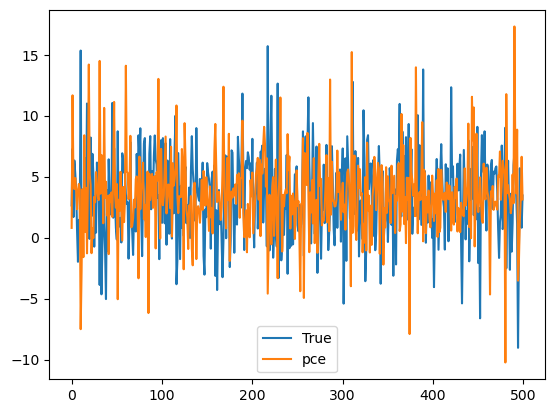

In [471]:
sample = np.random.uniform(-np.pi,np.pi, size=(500,3))

y_aPCE = evaluate_aPCE_Ishigami(pce_coef, 3, 6, sample)

y_true = Ishigami_Function(sample[:,0], sample[:,1], sample[:,2])

plt.plot(y_true, label = 'True')
plt.plot(y_aPCE, label = "pce")
plt.legend();


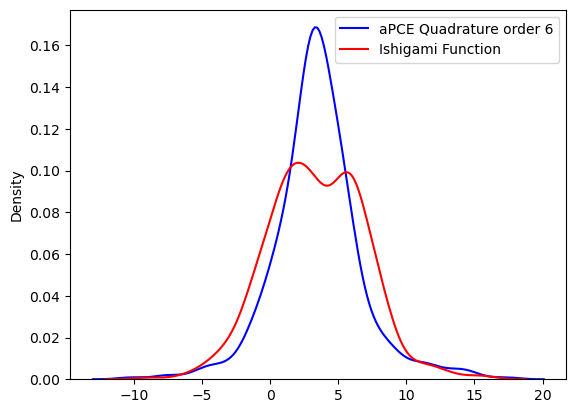

In [472]:
#plt.rcParams['figure.figsize'] = (6, 6)
sns.kdeplot(y_aPCE, color='b', label='aPCE Quadrature order 6')
sns.kdeplot(y_true.reshape(500), color='r', label='Ishigami Function')
plt.legend();

### PCE on Ishigami function

In [258]:
def PCE_Ishigami_Quadrature(d, max_deg, n_quad):
    """
    Compute the pce coefficients of the Ishigami Function
    input:
    d: int, number of parameters
    max_deg: int, the max degree so that individual degrees
             are not above it
    n_quad: int, number of quadrature points
    return:
    1d array, PCE coefficients
    """
    pce_index = multivariate_pce_index(d, max_deg)
    pce_coef = np.zeros(pce_index.shape[0])
    
    # quadrature
    # Finding the weights for x_1
    nodes1 = np.roots(legendre(n_quad))
    V = np.zeros((n_quad,n_quad))
    for i in range(n_quad):
        V[i,:] = nodes1**i
    b_cond = np.zeros(n_quad)
    for i in range(n_quad):
        b_cond[i] = integrate.quad(lambda x: x**i, -1, 1)[0]
    w_1 = np.linalg.inv(V)@b_cond
    print(nodes1)
    print(w_1)
    
    # Finding the weights for x_2
    nodes2 = np.roots(legendre(n_quad))
    V = np.zeros((n_quad,n_quad))
    for i in range(n_quad):
        V[i,:] = nodes2**i
    b_cond = np.zeros(n_quad)
    for i in range(n_quad):
        b_cond[i] = integrate.quad(lambda x: x**i, -1, 1)[0]
    w_2 = np.linalg.inv(V)@b_cond
    print(nodes2)
    
    # Finding the weights for x_3
    nodes3 = np.roots(legendre(n_quad))
    V = np.zeros((n_quad,n_quad))
    for i in range(n_quad):
        V[i,:] = nodes3**i
    b_cond = np.zeros(n_quad)
    for i in range(n_quad):
        b_cond[i] = integrate.quad(lambda x: x**i, -1, 1)[0]
    w_3 = np.linalg.inv(V)@b_cond
    print(nodes3)
    print(legendre(n_quad))
        
    # the index is for computing the quadrature
    quad_index = multivariate_pce_index(3, n_quad-1)
        
    for i in range(pce_coef.size):
        for j in range(quad_index.shape[0]):
            pce_coef[i] += Ishigami_Function(np.pi*nodes1[quad_index[j,0]],
                                         np.pi*nodes2[quad_index[j,1]],
                                         np.pi*nodes3[quad_index[j,2]])*\
            w_1[quad_index[j,0]]*w_2[quad_index[j,1]]*w_3[quad_index[j,2]]*\
            legendre(pce_index[i,0])(nodes1[quad_index[j,0]])*\
            legendre(pce_index[i,1])(nodes2[quad_index[j,1]])*\
            legendre(pce_index[i,2])(nodes3[quad_index[j,2]])
        pce_coef[i] /= 2/(2*pce_index[i,0]+1)
        pce_coef[i] /= 2/(2*pce_index[i,1]+1)
        pce_coef[i] /= 2/(2*pce_index[i,2]+1)

    return pce_coef

In [375]:
def PCE_Ishigami_Quadrature(d, max_deg, n_quad):
    """
    Compute the pce coefficients of the Ishigami Function
    input:
    d: int, number of parameters
    max_deg: int, the max degree so that individual degrees
             are not above it
    n_quad: int, number of quadrature points
    return:
    1d array, PCE coefficients
    """
    pce_index = multivariate_pce_index(d, max_deg)
    pce_coef = np.zeros(pce_index.shape[0])
    
    # quadrature
    # Finding the weights for x_1
    nodes1 = roots_legendre(n_quad)[0]
    w_1 = roots_legendre(n_quad)[1]
    
    # Finding the weights for x_2
    nodes2 = roots_legendre(n_quad)[0]
    w_2 = roots_legendre(n_quad)[1]
    
    # Finding the weights for x_3
    nodes3 = roots_legendre(n_quad)[0]
    w_3 = roots_legendre(n_quad)[1]
        
    # the index is for computing the quadrature
    quad_index = multivariate_pce_index(3, n_quad-1)

    for i in range(pce_coef.size):
        for j in range(quad_index.shape[0]):
            pce_coef[i] += Ishigami_Function(np.pi*nodes1[quad_index[j,0]],
                                         np.pi*nodes2[quad_index[j,1]],
                                         np.pi*nodes3[quad_index[j,2]])*\
            w_1[quad_index[j,0]]*w_2[quad_index[j,1]]*w_3[quad_index[j,2]]*\
            legendre(pce_index[i,0])(nodes1[quad_index[j,0]])*\
            legendre(pce_index[i,1])(nodes2[quad_index[j,1]])*\
            legendre(pce_index[i,2])(nodes3[quad_index[j,2]])
        pce_coef[i] /= 2/(2*pce_index[i,0]+1)
        pce_coef[i] /= 2/(2*pce_index[i,1]+1)
        pce_coef[i] /= 2/(2*pce_index[i,2]+1)

    return pce_coef

In [ ]:
    for i in range(pce_coef.size):
        for j in range(quad_index.shape[0]):
            pce_coef[i] += Ishigami_Function(np.pi*nodes1[quad_index[j,0]],
                                         np.pi*nodes2[quad_index[j,1]],
                                         np.pi*nodes3[quad_index[j,2]])*\
            w_1[quad_index[j,0]]*w_2[quad_index[j,1]]*w_3[quad_index[j,2]]*\
            legendre(pce_index[i,0])(nodes1[quad_index[j,0]])*\
            legendre(pce_index[i,1])(nodes2[quad_index[j,1]])*\
            legendre(pce_index[i,2])(nodes3[quad_index[j,2]])
        pce_coef[i] /= 2/(2*pce_index[i,0]+1)
        pce_coef[i] /= 2/(2*pce_index[i,1]+1)
        pce_coef[i] /= 2/(2*pce_index[i,2]+1)

In [320]:
    for i in range(pce_coef.size):
        for j in range(n_quad):
            for k in range(n_quad):
                for r in range(n_quad):
                    pce_coef[i] += w_1[j]*w_2[k]*w_3[r]*\
                                   Ishigami_Function(np.pi*nodes1[j], 
                                                     np.pi*nodes2[k], 
                                                     np.pi*nodes3[r])\
                    *legendre(pce_index[i][0])(nodes1[j]) \
                    *legendre(pce_index[i][1])(nodes2[k]) \
                    *legendre(pce_index[i][2])(nodes3[r])
        pce_coef[i] /= 2/(2*pce_index[i,0]+1)
        pce_coef[i] /= 2/(2*pce_index[i,1]+1)
        pce_coef[i] /= 2/(2*pce_index[i,2]+1)

NameError: name 'w_1' is not defined

In [376]:
pce_coef = PCE_Ishigami_Quadrature(3, 6, 10)

In [377]:
from scipy.special import roots_legendre

In [378]:
roots_legendre(10)

(array([-0.97390653, -0.86506337, -0.67940957, -0.43339539, -0.14887434,
         0.14887434,  0.43339539,  0.67940957,  0.86506337,  0.97390653]),
 array([0.06667134, 0.14945135, 0.21908636, 0.26926672, 0.29552422,
        0.29552422, 0.26926672, 0.21908636, 0.14945135, 0.06667134]))

In [379]:
def evaluate_PCE_Ishigami(pce_coef, d, max_deg, x):
    """
    evaluate pce expansion with maximum degree max_deg at the points x
    for Black-Scholes
    input:
    pce_coef: 1d array, the pce coefficients
    d: int, the number of parameter
    max_deg: int, the maximum degree
    x: 2d array, the points where the pce is evaluated. x.shape[1] = 3
    return
    val: 1d array of the same size as x.shape[0]
    """
    pce_index = multivariate_pce_index(d, max_deg)
    val = np.zeros(x.shape[0])
    for i in range(pce_index.shape[0]):    
        val += pce_coef[i]*\
                     legendre(pce_index[i][0])(x[:,0])* \
                     legendre(pce_index[i][1])(x[:,1])* \
                     legendre(pce_index[i][2])(x[:,2])
    return val

In [380]:
y_PCE = evaluate_PCE_Ishigami(pce_coef, 3, p, sample/np.pi)

In [381]:
np.mean(y_PCE)

0.34753982258060995

In [359]:
np.mean(y_true)

3.5846618049743637

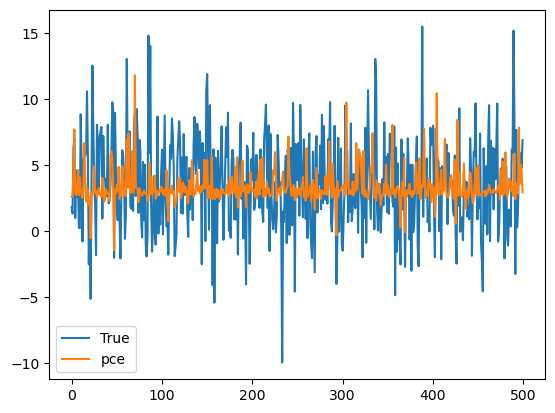

In [361]:
plt.plot(y_true, label = 'True')
plt.plot(y_PCE, label = "pce")
plt.legend();

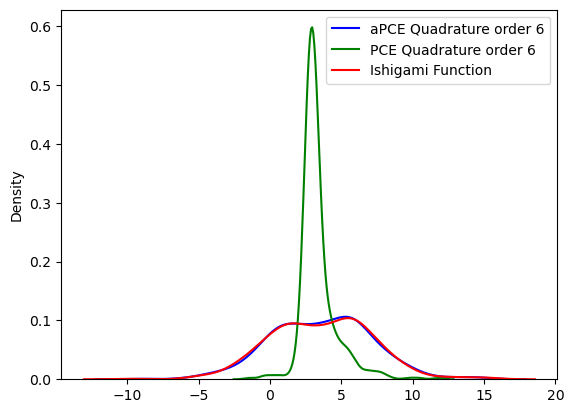

In [362]:
#plt.rcParams['figure.figsize'] = (6, 6)
sns.kdeplot(y_aPCE, color='b', label='aPCE Quadrature order 6')
sns.kdeplot(y_PCE, color='g', label='PCE Quadrature order 6')
sns.kdeplot(y_true.reshape(N), color='r', label='Ishigami Function')
plt.legend();

In [153]:
(y_true.reshape(N)).shape

(500,)

### Using LR

In [122]:
index = multivariate_pce_index(3, p)
Phi = np.zeros((N, n))

for i in range(n):
    Phi[:,i] =  Pol_eval(P1_norm[index[i][0],:], x_1) \
               *Pol_eval(P2_norm[index[i][1],:], x_2) \
               *Pol_eval(P3_norm[index[i][2],:], x_3)
    
model = LinearRegression(fit_intercept = False).fit(Phi, Y)

In [123]:
model = LinearRegression(fit_intercept = False).fit(Phi, Y)

In [124]:
np.mean(Phi@model.coef_.transpose())

3.4753114674428

In [125]:
Y_pce = Phi@model.coef_.transpose()

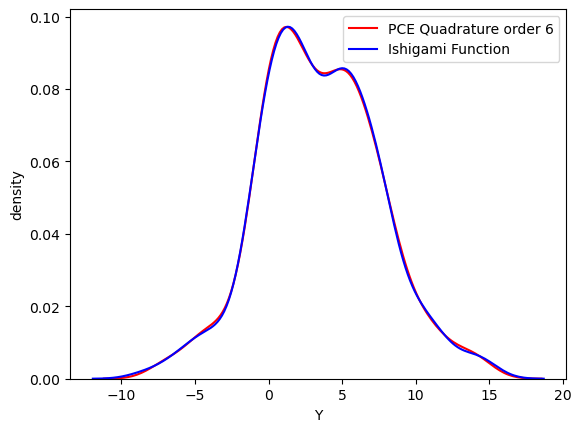

In [126]:
#plt.rcParams['figure.figsize'] = (6, 6)
sns.kdeplot(Y_pce.reshape(N), color = 'r', label='PCE Quadrature order 6')
sns.kdeplot(Y.reshape(N), color = 'b', label='Ishigami Function')
plt.legend()
plt.xlabel('Y')
plt.ylabel('density');

## Making one Function to Calculate any Degree n

In [26]:
## Checking Polynomials we created are orthogonal
def Pol_eval(coeff, x):
    deg = coeff.shape[0]
    val = 0
    for i in range(deg):
        val += coeff[i]*x**i
        
    return val

def Int_eval(coeff1, coeff2, dat):
    s = np.mean(Pol_eval(coeff1, dat)*Pol_eval(coeff2, dat))
    return s

In [27]:
def aPCE(p, dat):
    n = int(math.factorial(d + p)/(math.factorial(d)*math.factorial(p)))

    #### Calculating the Orthogonal Polynomials
    P = np.zeros((p+1, p+1))

    P[0,0] = 1

    mu = np.zeros(2*p) 
    for i in range(2*p): 
        mu[i] = np.mean(dat**i)

    mu_mat = np.zeros((p, p+1))
    for i in range(p):
        mu_mat[i,:] = mu[i:(p+1+i)]

    for i in range(1,p+1):
        A = np.zeros((i+1, i+1))
        A[-1,-1] = 1
        A[0:i,:] = mu_mat[0:i, 0:i+1]
        b = A[-1]
        a = np.zeros(p+1)
        a[0:i+1] = np.linalg.inv(A)@b
        P[i, :] = a.transpose()
    
    P_norm = np.zeros((p+1, p+1))
    for i in range(p+1):
        P_norm[i,:] = P[i,:]/np.sqrt(Int_eval(P[i,:], P[i,:], dat))
    
    # Finding the weights for c_i
    nodes = np.roots(P_norm[-1][::-1])
    V = np.zeros((p,p))
    for i in range(p):
        V[i,:] = nodes**i
    b_cond = np.zeros(p)
    for i in range(p):
        b_cond[i] = np.mean(dat**i)
    w_s = np.linalg.inv(V)@b_cond

    c = np.zeros(p+1)
    for i in range(p+1):
        c[i] = np.dot(w_s, np.exp(-nodes)*Pol_eval(P_norm[i,:], nodes))
        
    r = 0
    for i in range(n):
        r += c[i]*Pol_eval(P_norm[i,:], dat)
    return r

In [52]:
def aPCE_LR(p, dat):
    n = int(math.factorial(d + p)/(math.factorial(d)*math.factorial(p)))

    #### Calculating the Orthogonal Polynomials
    P = np.zeros((p+1, p+1))

    P[0,0] = 1

    mu = np.zeros(2*p) 
    for i in range(2*p): 
        mu[i] = np.mean(dat**i)

    mu_mat = np.zeros((p, p+1))
    for i in range(p):
        mu_mat[i,:] = mu[i:(p+1+i)]

    for i in range(1,p+1):
        A = np.zeros((i+1, i+1))
        A[-1,-1] = 1
        A[0:i,:] = mu_mat[0:i, 0:i+1]
        b = A[-1]
        a = np.zeros(p+1)
        a[0:i+1] = np.linalg.inv(A)@b
        P[i, :] = a.transpose()
    
    P_norm = np.zeros((p+1, p+1))
    for i in range(p+1):
        P_norm[i,:] = P[i,:]/np.sqrt(Int_eval(P[i,:], P[i,:], dat))
    
    # Finding the weights for c_i
    Phi = np.zeros((N, n))

    for i in range(n):
        Phi[:,i] =  Pol_eval(P_norm[i,:], dat)
    print(Phi.shape)

    model = LinearRegression(fit_intercept = False).fit(Phi, np.exp(-dat))
    return Phi@np.c_[model.coef_]

## Solutions

In [56]:
aPCE_mean = np.zeros(6)
PCE_mean = np.zeros(6)
aPCE_var = np.zeros(6)
PCE_var = np.zeros(6)

for i in range(1,7):
    aPCE_mean[i-1] = np.mean(aPCE(i , dat))
    PCE_mean[i-1] = np.mean(PCE(i, dat))
    aPCE_var[i-1] = np.var(aPCE(i, dat))
    PCE_var[i-1] = np.var(PCE(i, dat))

In [57]:
err_aPCE = np.abs(aPCE_mean-y_mc)/np.abs(y_mc)
err_PCE = np.abs(PCE_mean-y_mc)/np.abs(y_mc)

err_aPCE_var = np.abs(aPCE_var-y_mc_var)/np.abs(y_mc_var)
err_PCE_var = np.abs(PCE_var-y_mc_var)/np.abs(y_mc_var)

In [58]:
aPCE_mean

array([0.13391747, 0.17949712, 0.18446302, 0.18476028, 0.18477074,
       0.18477096])

In [59]:
y_mc

0.17761563760791596

In [60]:
PCE_mean

array([0.20020131, 0.20020131, 0.18053077, 0.18405871, 0.18468611,
       0.18486346])

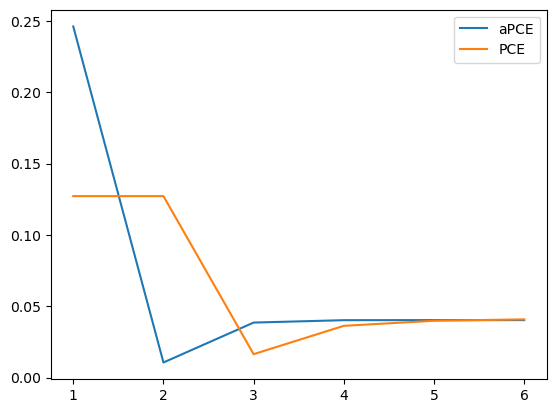

In [61]:
plt.plot(range(1,7), err_aPCE, label = "aPCE")
plt.plot(range(1,7), err_PCE, label = "PCE")
#plt.ylim(0, 10**(-1))
plt.legend()

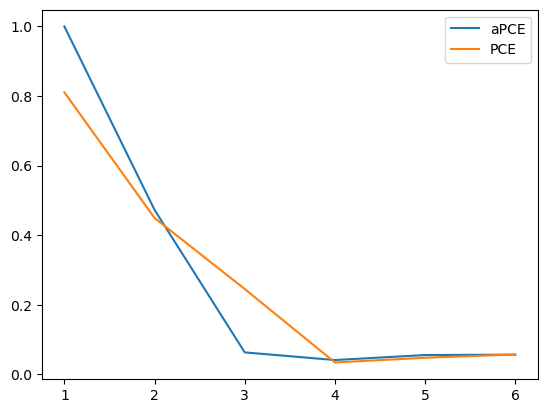

In [62]:
plt.plot(range(1,7), err_aPCE_var, label = "aPCE")
plt.plot(range(1,7), err_PCE_var, label = "PCE")
#plt.ylim(0, 10**(-1))
plt.legend()